### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from kmodes.kprototypes import KPrototypes
import scipy.cluster.hierarchy as sch

## Exploratory Data Analysis (EDA)

In [2]:
df= pd.read_csv("TSA2002_2015.csv", low_memory=False)

In [3]:
df.shape

(204270, 13)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204270 entries, 0 to 204269
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Claim Number   204267 non-null  object
 1   Date Received  204004 non-null  object
 2   Incident Date  202084 non-null  object
 3   Airport Code   195743 non-null  object
 4   Airport Name   195743 non-null  object
 5   Airline Name   169893 non-null  object
 6   Claim Type     196354 non-null  object
 7   Claim Site     203527 non-null  object
 8   Item           200301 non-null  object
 9   Claim Amount   200224 non-null  object
 10  Status         204262 non-null  object
 11  Close Amount   135315 non-null  object
 12  Disposition    131359 non-null  object
dtypes: object(13)
memory usage: 20.3+ MB


In [5]:
df.head()

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
0,0909802M,04-Jan-02,12/12/2002 00:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Other,$350.00,Approved,$350.00,Approve in Full
1,0202417M,02-Feb-02,1/16/2004 0:00,SEA,Seattle-Tacoma International,NaN,Property Damage,Checked Baggage,Luggage (all types including footlockers),$100.00,Settled,$50.00,Settle
2,0202445M,04-Feb-02,11/26/2003 0:00,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Cell Phones,$278.88,Settled,$227.92,Settle
3,0909816M,07-Feb-02,01/06/2003 00:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),$50.00,Approved,$50.00,Approve in Full
4,2.00503E+12,18-Feb-02,02/05/2005 00:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,$84.79,Approved,$84.79,Approve in Full


In [6]:
df.shape

(204270, 13)

### Data Cleaning

In [7]:
#Converting the Date Received Column to datetime format

df["Date Received"]= pd.to_datetime(df["Date Received"], format="mixed")

In [8]:
#Converting the Incident Date column to datetime format

df["Incident Date"]= pd.to_datetime(df["Incident Date"], errors="coerce", format="mixed")

In [9]:
#Checking the count of missing values per column

df.isna().sum()

Claim Number         3
Date Received      266
Incident Date     2350
Airport Code      8527
Airport Name      8527
Airline Name     34377
Claim Type        7916
Claim Site         743
Item              3969
Claim Amount      4046
Status               8
Close Amount     68955
Disposition      72911
dtype: int64

In [10]:
#Checking the percentage of missing values per column

df.isnull().mean() *100

Claim Number      0.001469
Date Received     0.130220
Incident Date     1.150438
Airport Code      4.174377
Airport Name      4.174377
Airline Name     16.829197
Claim Type        3.875263
Claim Site        0.363734
Item              1.943017
Claim Amount      1.980712
Status            0.003916
Close Amount     33.756792
Disposition      35.693445
dtype: float64

The dataset has varying percentages of missing values across several columns:

- Claim Number: 0.0015% missing, minimal impact.
- Date Received: 0.13% missing, relatively low.
- Incident Date: 1.15% missing, manageable.
- Airport Code/Name: 4.17% missing, moderate.
- Airline Name: 16.83% missing, significant.
- Claim Type: 3.88% missing, moderate.
- Claim Site: 0.36% missing, low.
- Item: 1.94% missing, moderate.
- Claim Amount: 1.98% missing, moderate.
- Close Amount: 33.76% missing, substantial.
- Disposition: 35.69% missing, substantial.

In [11]:
# Checking the counts of all the different types of Claim Status

df["Status"].value_counts()

Status
Denied                                                                                                                           68339
Approved                                                                                                                         34999
Deny                                                                                                                             28237
Settled                                                                                                                          27958
-                                                                                                                                12752
Approve in Full                                                                                                                  12364
Canceled                                                                                                                          7018
Settle                                          

In [12]:
#Dropping Status Column

df1= df.drop("Status", axis=1)

In [13]:
#Checking for duplicates

df1[df1.duplicated()]

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Close Amount,Disposition
16842,2.00405E+12,2003-09-26,2003-09-13,NaN,NaN,NaN,Property Damage,Checked Baggage,DVD/CD Players,$31.96,NaN,NaN
44763,2.00409E+12,2004-09-14,2004-07-29,F,Foreign airport,NaN,Property Damage,Checked Baggage,Luggage (all types including footlockers),$300.00,$0.00,Deny
44764,2.00409E+12,2004-09-14,2004-07-29,F,Foreign airport,NaN,Property Damage,Checked Baggage,Luggage (all types including footlockers),$300.00,$0.00,Deny
46766,2.00411E+12,2004-10-05,2004-09-05,SEA,Seattle-Tacoma International,Northwest Airlines,Property Damage,Checked Baggage,Locks,$120.00,$120.00,Deny
60157,2.00504E+12,2005-03-29,2005-03-07,EWR,Newark International Airport,Continental Airlines,Passenger Property Loss,Checked Baggage,Locks,$30.00,$30.00,Approve in Full
...,...,...,...,...,...,...,...,...,...,...,...,...
200148,2.01507E+12,2015-07-22,2015-07-10,LAX,Los Angeles International Airport,Jet Blue,Property Damage,Checked Baggage,Baggage/Cases/Purses,$0.00,NaN,NaN
203176,2.01512E+12,2015-12-04,2015-12-02,SAN,San Diego International,Delta Air Lines,Passenger Property Loss,Checked Baggage,Audio/Video,-,NaN,NaN
204201,2.01509E+12,2015-08-14,2013-08-16,ZZX,Non TSA Airport (motor vehicle),-,Personal Injury,Motor Vehicle,-,-,NaN,NaN
204202,2.01509E+12,2015-08-14,2013-08-16,ZZX,Non TSA Airport (motor vehicle),-,Personal Injury,Motor Vehicle,-,-,NaN,NaN


In [14]:
df1.duplicated().sum()

115

There are 115 entries with the same claim number.

In [15]:
#Dropping the duplicates

df1= df1.drop_duplicates()

In [16]:
#Dropping null values for Disposition

df1= df1.dropna(subset="Disposition")

In [17]:
df1.isna().sum()

Claim Number         0
Date Received      119
Incident Date      915
Airport Code      4181
Airport Name      4181
Airline Name     28307
Claim Type        5886
Claim Site         277
Item              2892
Claim Amount       766
Close Amount      1473
Disposition          0
dtype: int64

In [18]:
#Dropping null values for incident date

df1.dropna(subset="Incident Date", inplace=True)

In [19]:
#Dropping Claim Number column because it's irrelevant for our analysis

df2= df1.drop("Claim Number", axis=1)

In [20]:
#Creating Date Received Month, Date Received Year, Incident Month and Incident Year columns
df2["Date Received Month"]= df2["Date Received"].dt.strftime("%b")
df2["Incident Month"]= df2["Incident Date"].dt.strftime("%b")
df2["Date Received Year"]= df2["Date Received"].dt.year
df2["Incident Year"]= df2["Incident Date"].dt.year

In [21]:
#Dropping Null values for Date received
df2.dropna(subset="Date Received", inplace=True)

In [22]:
#Dropping Airline name column
df2= df2.drop("Airline Name", axis=1)

In [23]:
#Dropping null values for airport code, airport name, claim type, claim site and item

df2.dropna(subset=["Airport Code", "Airport Name", "Claim Type", "Claim Site", "Item"], inplace=True)

In [24]:
df2.isna().sum()

Date Received             0
Incident Date             0
Airport Code              0
Airport Name              0
Claim Type                0
Claim Site                0
Item                      0
Claim Amount            174
Close Amount           1277
Disposition               0
Date Received Month       0
Incident Month            0
Date Received Year        0
Incident Year             0
dtype: int64

In [25]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118925 entries, 0 to 145143
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Date Received        118925 non-null  datetime64[ns]
 1   Incident Date        118925 non-null  datetime64[ns]
 2   Airport Code         118925 non-null  object        
 3   Airport Name         118925 non-null  object        
 4   Claim Type           118925 non-null  object        
 5   Claim Site           118925 non-null  object        
 6   Item                 118925 non-null  object        
 7   Claim Amount         118751 non-null  object        
 8   Close Amount         117648 non-null  object        
 9   Disposition          118925 non-null  object        
 10  Date Received Month  118925 non-null  object        
 11  Incident Month       118925 non-null  object        
 12  Date Received Year   118925 non-null  float64       
 13  Incident Year      

In [26]:
#Removing the dollar signs and converting the data types of claim amount and close amount to float.
df2["Claim Amount"]= df2["Claim Amount"].str.replace('[$;]', '', regex=True).astype("float")
df2["Close Amount"]= df2["Close Amount"].str.replace('[$;]',  '', regex=True).astype("float")

In [27]:
#Preliminary Descriptive Statistics of Numerical Features

df2.describe().T

,count,mean,min,25%,50%,75%,max,std
Date Received,118925,2006-03-12 22:51:05.441244544,1994-01-05 00:00:00,2004-08-27 00:00:00,2005-12-21 00:00:00,2007-09-19 00:00:00,2055-05-17 00:00:00,NaN
Incident Date,118925,2006-01-30 05:07:59.528778496,1996-05-08 00:00:00,2004-07-12 00:00:00,2005-11-10 00:00:00,2007-08-16 00:00:00,2010-06-22 00:00:00,NaN
Claim Amount,118751.0,3165.709638,0.0,62.485,175.0,450.0,125000000.0,470249.438914
Close Amount,117648.0,94.657721,0.0,0.0,0.0,72.02,250000.0,809.146145
Date Received Year,118925.0,2005.704831,1994.0,2004.0,2005.0,2007.0,2055.0,1.868651
Incident Year,118925.0,2005.580988,1996.0,2004.0,2005.0,2007.0,2010.0,1.869959


In [28]:
#Filling Null Values of Claim Amount and Close Amount by their medians

df2["Claim Amount"]= df2["Claim Amount"].fillna(df2["Claim Amount"].median())
df2["Close Amount"]= df2["Close Amount"].fillna(df2["Close Amount"].median())

In [29]:
#Final Descriptive Statistics of Numerical Features

df2.describe().T

,count,mean,min,25%,50%,75%,max,std
Date Received,118925,2006-03-12 22:51:05.441244544,1994-01-05 00:00:00,2004-08-27 00:00:00,2005-12-21 00:00:00,2007-09-19 00:00:00,2055-05-17 00:00:00,NaN
Incident Date,118925,2006-01-30 05:07:59.528778496,1996-05-08 00:00:00,2004-07-12 00:00:00,2005-11-10 00:00:00,2007-08-16 00:00:00,2010-06-22 00:00:00,NaN
Claim Amount,118925.0,3161.33391,0.0,62.78,175.0,450.0,125000000.0,469905.311377
Close Amount,118925.0,93.6413,0.0,0.0,0.0,70.0,250000.0,804.849265
Date Received Year,118925.0,2005.704831,1994.0,2004.0,2005.0,2007.0,2055.0,1.868651
Incident Year,118925.0,2005.580988,1996.0,2004.0,2005.0,2007.0,2010.0,1.869959


- The cleaned dataset now contains 118,925 total number of entries.
- Date Received: Mean date of 2006-03-12. The earliest entry is from 1994-01-05, and the latest is 2055-05-17.
- Incident Date: Mean date of 2006-01-30, with a range from 1996-05-08 to 2010-06-22.
- Claim Amount: A mean of $3,165.71, ranging from $0 to $125,000,000, with a large standard deviation of $470,249.44, indicating high variability.
- Close Amount: Mean of $94.66, ranging from $0 to $250,000, with a smaller deviation of $809.15.
- Both Date Received Year and Incident Year indicate a mean of approximately 2005

In [30]:
#Descriptive Statistics of Categorical Variables

df2.describe(include="object").T

,count,unique,top,freq
Airport Code,118925,424,LAX,5923
Airport Name,118925,424,Los Angeles International Airport,5923
Claim Type,118925,6,Passenger Property Loss,71566
Claim Site,118925,4,Checked Baggage,97029
Item,118925,3193,Other,24295
Disposition,118925,3,Deny,63279
Date Received Month,118925,12,Aug,11015
Incident Month,118925,12,Aug,10694


The "Airport Code" and "Airport Name" fields have 424 unique values, with the most frequent being "LAX" and "Los Angeles International Airport," each appearing 5,923 times. The "Claim Type" includes six categories, with "Passenger Property Loss" being the most frequent at 71,566 occurrences. The "Claim Site" is dominated by "Checked Baggage" claims, which account for 97,029 entries. The most frequent "Item" category is "Other," with 24,295 instances. "Disposition" shows three outcomes, with "Deny" being the most frequent at 63,279 entries. August is the most common month for both "Date Received" and "Incident Month.

In [31]:
df2

,Date Received,Incident Date,Airport Code,Airport Name,Claim Type,Claim Site,Item,Claim Amount,Close Amount,Disposition,Date Received Month,Incident Month,Date Received Year,Incident Year
0,2002-01-04,2002-12-12 00:00:00,EWR,Newark International Airport,Property Damage,Checkpoint,Other,350.00,350.00,Approve in Full,Jan,Dec,2002.0,2002
1,2002-02-02,2004-01-16 00:00:00,SEA,Seattle-Tacoma International,Property Damage,Checked Baggage,Luggage (all types including footlockers),100.00,50.00,Settle,Feb,Jan,2002.0,2004
2,2002-02-04,2003-11-26 00:00:00,STL,Lambert St. Louis International,Property Damage,Checked Baggage,Cell Phones,278.88,227.92,Settle,Feb,Nov,2002.0,2003
3,2002-02-07,2003-01-06 00:00:00,MIA,Miami International Airport,Property Damage,Checkpoint,Luggage (all types including footlockers),50.00,50.00,Approve in Full,Feb,Jan,2002.0,2003
4,2002-02-18,2005-02-05 00:00:00,MCO,Orlando International Airport,Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,84.79,84.79,Approve in Full,Feb,Feb,2002.0,2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145138,2009-12-31,2009-12-14 00:00:00,EWR,Newark International Airport,Property Damage,Checked Baggage,Luggage (all types including footlockers),175.90,0.00,Deny,Dec,Dec,2009.0,2009
145139,2009-12-31,2009-12-17 07:55:00,BWI,Baltimore/Washington Intl Thurgood Marshall,Passenger Property Loss,Checked Baggage,Cell Phones (smartphone type-blackberry; iphon...,695.00,0.00,Deny,Dec,Dec,2009.0,2009
145140,2009-12-31,2009-12-15 00:00:00,SMF,Sacramento International Airport,Passenger Property Loss,Checked Baggage,Locks,25.50,0.00,Deny,Dec,Dec,2009.0,2009
145141,2009-12-31,2009-12-16 10:00:00,ENV,Wendover Municipal Airport,Passenger Property Loss,Checked Baggage,Locks,20.00,0.00,Deny,Dec,Dec,2009.0,2009


### Data Visualization

In [32]:
#Separating into numerical and categorical features
num_cols= df2.select_dtypes(include=[np.number]).columns
cat_cols= df2.select_dtypes(exclude= [np.number]).columns

#Separating into numerical and categorical data
num_df= df2[num_cols]
cat_df= df2[cat_cols]

In [33]:
cat_cols

Index(['Date Received', 'Incident Date', 'Airport Code', 'Airport Name',
       'Claim Type', 'Claim Site', 'Item', 'Disposition',
       'Date Received Month', 'Incident Month'],
      dtype='object')

#### Univariate Analysis

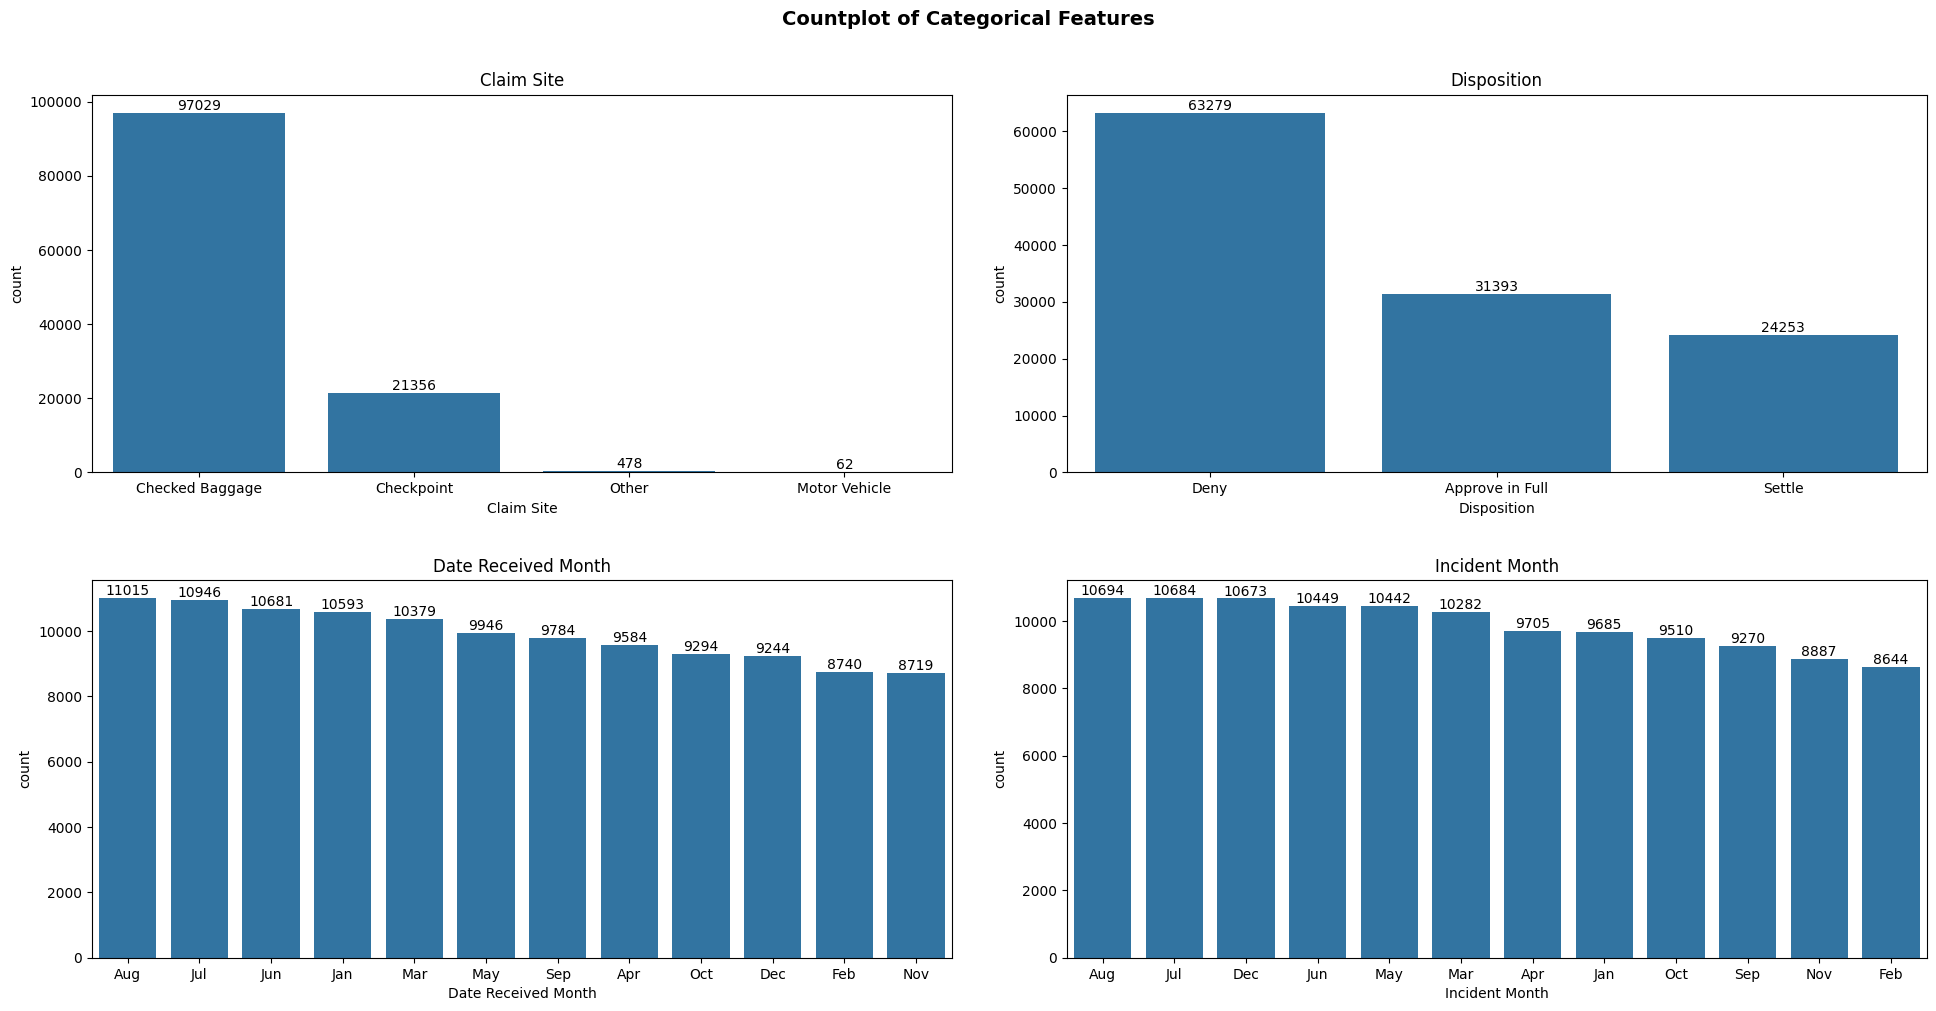

In [34]:
#Countplots of Categorical Features

plt.figure(figsize=(20,20))
plt.suptitle("Countplot of Categorical Features", fontweight='bold', fontsize=14)

for i, col in enumerate(cat_df.drop(['Claim Type', 'Date Received', 'Incident Date', 'Airport Code', 'Airport Name', 'Item'], axis=1)):
    plt.subplot(4,2, i+1)
    ax=sns.countplot(x=cat_df[col], order=cat_df[col].value_counts().index)
    ax.bar_label(ax.containers[0])
    plt.title(f"{col}")
    plt.tight_layout(pad=3)


The analysis of the categorical features in the dataset, as depicted in the count plots, provides insightful observations regarding the distribution of claim data.

- Claim Site: The majority of claims (81.6%) occurred with Checked Baggage (97,029), followed by Checkpoint with 17.9%. Motor vehicle-related claims are rare (0.05%).
- Disposition: 53.2% of claims were denied, while 26.4% were approved in full and 20.4% were settled.
- Date Received Month: There is a relatively even distribution across months, with August being the highest at 9.3% and February the lowest at 7.3%.
- Incident Month: Similarly, the incident month data shows a balanced distribution. Notably, July (9%) and August (9%) have the highest frequencies, while February is the lowest with 7.3%.

In [35]:
#Top 10 airports with most number of claims reported

top_10_airports= cat_df["Airport Name"].value_counts().head(10)
top_10_airports

Airport Name
Los Angeles International Airport                   5923
John F. Kennedy International                       4596
Chicago O'Hare International Airport                4521
Newark International Airport                        4389
Miami International Airport                         3790
Orlando International Airport                       3497
Seattle-Tacoma International                        3398
Hartsfield-Jackson Atlanta International Airport    3297
Phoenix Sky Harbor International                    3196
McCarran International                              3088
Name: count, dtype: int64

In [36]:
#Dataframe with top 10 airports

top_10_airports = df2["Airport Name"].value_counts().head(10).index
top_10_df = df2[df2["Airport Name"].isin(top_10_airports)]
top_10_df

,Date Received,Incident Date,Airport Code,Airport Name,Claim Type,Claim Site,Item,Claim Amount,Close Amount,Disposition,Date Received Month,Incident Month,Date Received Year,Incident Year
0,2002-01-04,2002-12-12 00:00:00,EWR,Newark International Airport,Property Damage,Checkpoint,Other,350.00,350.00,Approve in Full,Jan,Dec,2002.0,2002
1,2002-02-02,2004-01-16 00:00:00,SEA,Seattle-Tacoma International,Property Damage,Checked Baggage,Luggage (all types including footlockers),100.00,50.00,Settle,Feb,Jan,2002.0,2004
3,2002-02-07,2003-01-06 00:00:00,MIA,Miami International Airport,Property Damage,Checkpoint,Luggage (all types including footlockers),50.00,50.00,Approve in Full,Feb,Jan,2002.0,2003
4,2002-02-18,2005-02-05 00:00:00,MCO,Orlando International Airport,Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,84.79,84.79,Approve in Full,Feb,Feb,2002.0,2005
9,2002-06-25,2002-05-04 00:00:00,ATL,Hartsfield-Jackson Atlanta International Airport,Passenger Property Loss,Checkpoint,Jewelry - Fine,4457.29,0.00,Deny,Jun,May,2002.0,2002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145128,2009-12-30,2009-12-09 20:30:00,LAS,McCarran International,Property Damage,Checkpoint,Clothing - Shoes; belts; accessories; etc.,180.00,163.12,Settle,Dec,Dec,2009.0,2009
145131,2009-12-30,2009-11-16 00:00:00,LAX,Los Angeles International Airport,Property Damage,Checked Baggage,Other,85.00,42.50,Settle,Dec,Nov,2009.0,2009
145133,2009-12-30,2009-11-02 00:00:00,ORD,Chicago O'Hare International Airport,Passenger Property Loss,Checked Baggage,DVD/CD Players; Handbags & Purses (leather or ...,546.95,514.73,Settle,Dec,Nov,2009.0,2009
145138,2009-12-31,2009-12-14 00:00:00,EWR,Newark International Airport,Property Damage,Checked Baggage,Luggage (all types including footlockers),175.90,0.00,Deny,Dec,Dec,2009.0,2009


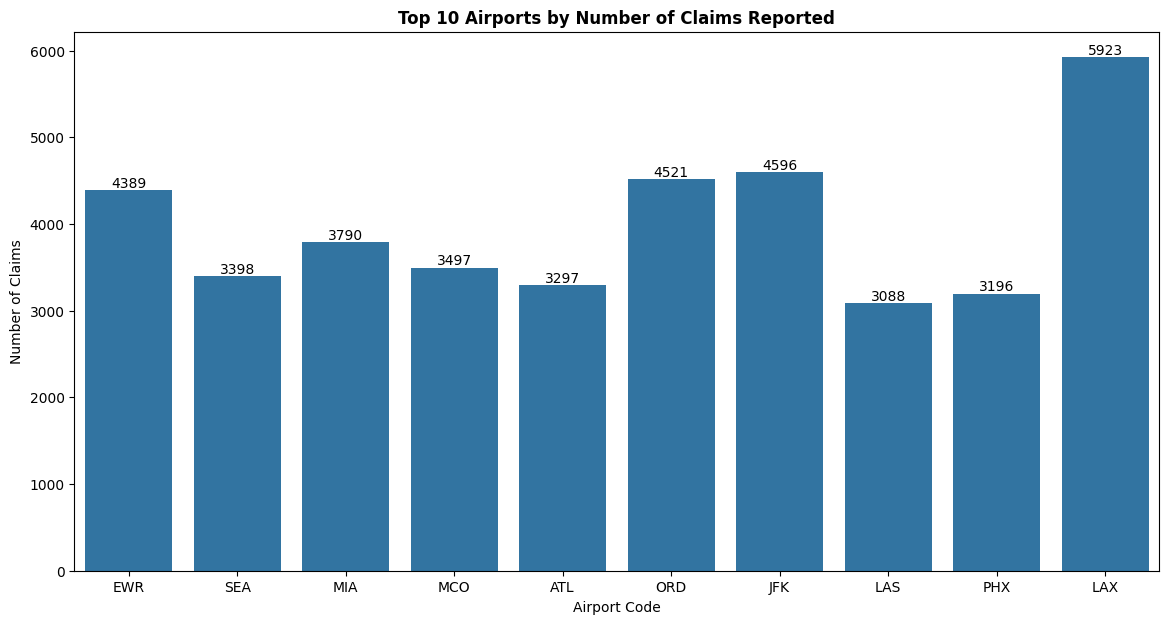

In [37]:
#Countplot of top 10 airports

plt.figure(figsize=(14,7))

ax= sns.countplot(x=top_10_df["Airport Code"])
ax.bar_label(ax.containers[0])
plt.title("Top 10 Airports by Number of Claims Reported", fontweight='bold')
plt.ylabel("Number of Claims")
plt.show()

The graph shows the top 10 airports with the highest number of claims reported. Los Angeles International Airport (LAX) stands out with the highest number of claims, totaling 5,923, followed by John F. Kennedy International Airport (JFK) with 4,596, and Chicago O'Hare International Airport (ORD) with 4,521 claims. On the lower end, airports like Seattle-Tacoma International Airport (SEA) and Harry Reid International Airport (LAS) report fewer claims, with 3,398 and 3,088 claims, respectively. This distribution indicates a significant disparity in claim reports across these major airports.

In [38]:
top_10_claimtype= df2["Claim Type"].value_counts().head(10).index
top_10_claimtype_df= df2[df2["Claim Type"].isin(top_10_claimtype)]

top_10_claimtype_df

,Date Received,Incident Date,Airport Code,Airport Name,Claim Type,Claim Site,Item,Claim Amount,Close Amount,Disposition,Date Received Month,Incident Month,Date Received Year,Incident Year
0,2002-01-04,2002-12-12 00:00:00,EWR,Newark International Airport,Property Damage,Checkpoint,Other,350.00,350.00,Approve in Full,Jan,Dec,2002.0,2002
1,2002-02-02,2004-01-16 00:00:00,SEA,Seattle-Tacoma International,Property Damage,Checked Baggage,Luggage (all types including footlockers),100.00,50.00,Settle,Feb,Jan,2002.0,2004
2,2002-02-04,2003-11-26 00:00:00,STL,Lambert St. Louis International,Property Damage,Checked Baggage,Cell Phones,278.88,227.92,Settle,Feb,Nov,2002.0,2003
3,2002-02-07,2003-01-06 00:00:00,MIA,Miami International Airport,Property Damage,Checkpoint,Luggage (all types including footlockers),50.00,50.00,Approve in Full,Feb,Jan,2002.0,2003
4,2002-02-18,2005-02-05 00:00:00,MCO,Orlando International Airport,Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,84.79,84.79,Approve in Full,Feb,Feb,2002.0,2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145138,2009-12-31,2009-12-14 00:00:00,EWR,Newark International Airport,Property Damage,Checked Baggage,Luggage (all types including footlockers),175.90,0.00,Deny,Dec,Dec,2009.0,2009
145139,2009-12-31,2009-12-17 07:55:00,BWI,Baltimore/Washington Intl Thurgood Marshall,Passenger Property Loss,Checked Baggage,Cell Phones (smartphone type-blackberry; iphon...,695.00,0.00,Deny,Dec,Dec,2009.0,2009
145140,2009-12-31,2009-12-15 00:00:00,SMF,Sacramento International Airport,Passenger Property Loss,Checked Baggage,Locks,25.50,0.00,Deny,Dec,Dec,2009.0,2009
145141,2009-12-31,2009-12-16 10:00:00,ENV,Wendover Municipal Airport,Passenger Property Loss,Checked Baggage,Locks,20.00,0.00,Deny,Dec,Dec,2009.0,2009


Text(0, 0.5, 'Number of Claims')

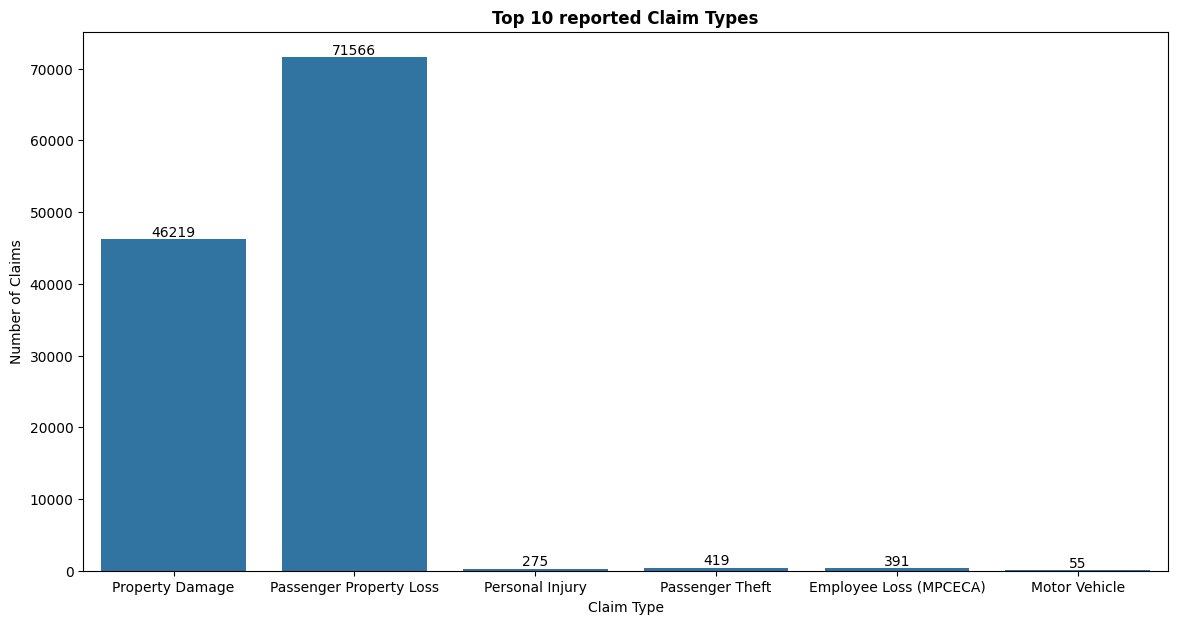

In [39]:
#Count plot of top 10 Cliaim Types

plt.figure(figsize=(14,7))
ax= sns.countplot(x=top_10_claimtype_df["Claim Type"])
ax.bar_label(ax.containers[0])
plt.title("Top 10 reported Claim Types", fontweight='bold')
plt.ylabel("Number of Claims")

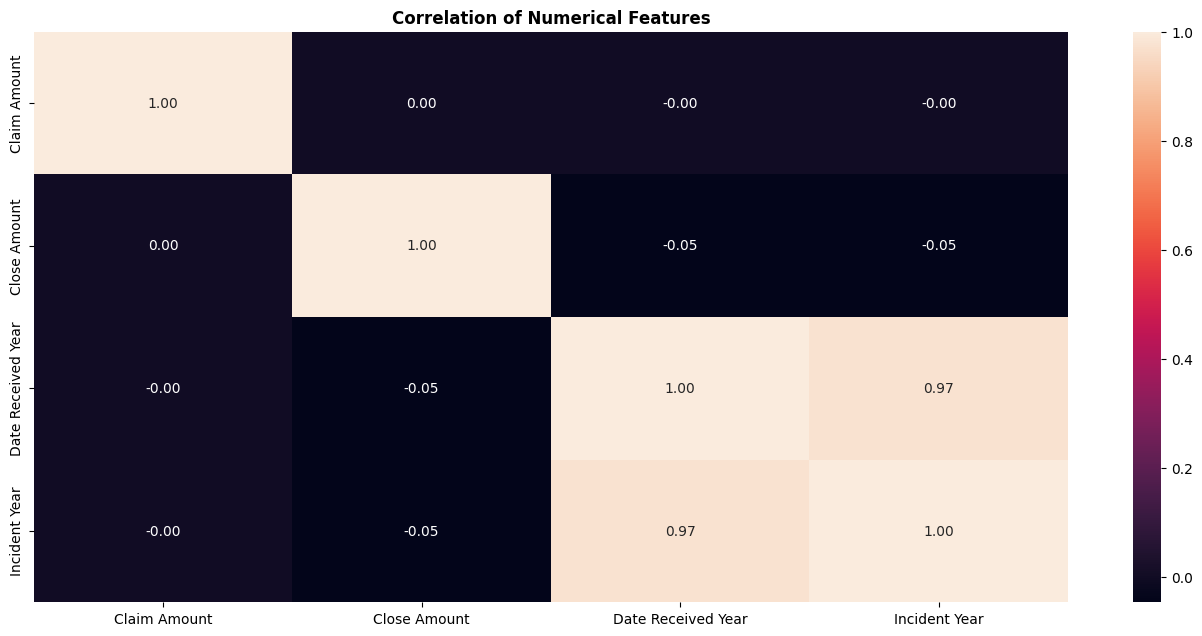

In [40]:
#Correlation Analysis
plt.figure(figsize=(14,7))
sns.heatmap(num_df.corr(), annot=True, fmt= ".2f")
plt.title("Correlation of Numerical Features", fontweight='bold')
plt.tight_layout(pad=3)

The heatmap displays the correlation matrix of four numerical features: Claim Amount, Close Amount, Date Received Year, and Incident Year. A strong positive correlation of 0.97 is observed between Date Received Year and Incident Year, indicating that incidents and claims occurred close together in time. However, there is minimal correlation between the Claim Amount and other variables, including the Close Amount (0.00), which suggests that claim payouts don't have a direct relationship with the initial claim amounts. Close Amount is also weakly correlated with all other features.

#### Detecting Outliers

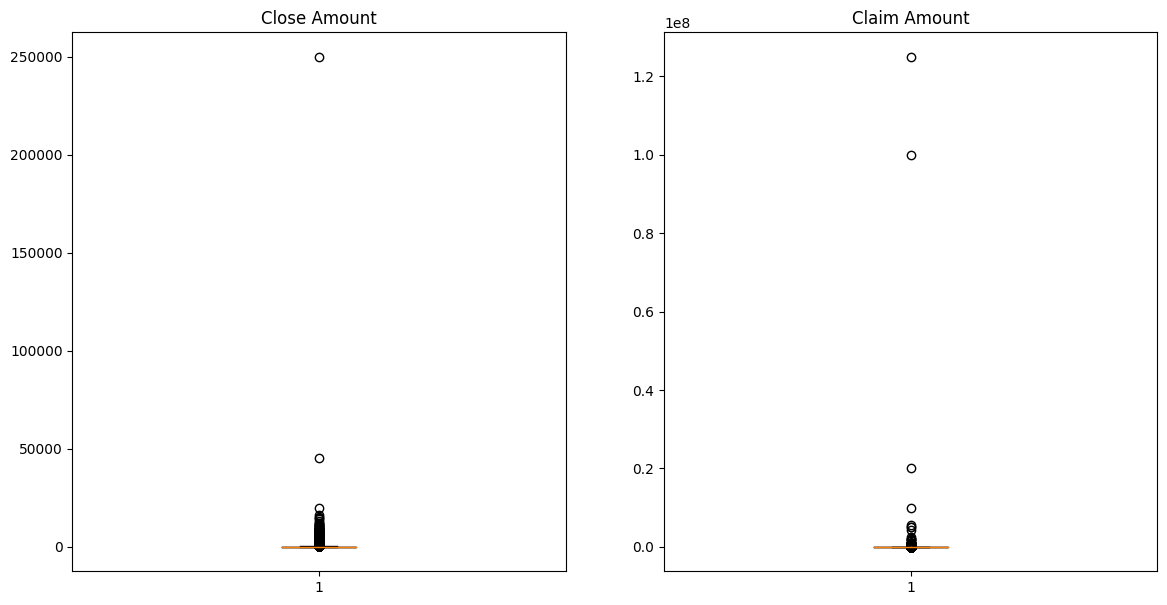

In [41]:
plt.subplots(1,2, figsize=(14,7))

plt.subplot(1,2,1)
plt.boxplot(x=df2["Close Amount"])
plt.title("Close Amount")

plt.subplot(1,2,2)
plt.boxplot(x=df2["Claim Amount"])
plt.title("Claim Amount")

plt.show()

For both amounts, most data points are clustered around lower values, with a few extreme values significantly higher, indicating outliers. The Claim Amount shows a more pronounced range, with some values reaching the 1e8 mark. The whiskers in both plots are relatively short, suggesting limited variability within the bulk of the data, and the outliers suggest that a small number of claims are exceptionally high compared to the majority.

In [42]:
#Exploring the Extreme Outliers

def get_outliers(df, col):
    Q1= df[col].quantile(0.25)
    Q3= df[col].quantile(0.75)
    
    IQR= Q3-Q1
    
    #Getting the points that are  150 times greater than the upper bound
    extreme_outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 150 * IQR)]
    extreme_outlier_indices = extreme_outliers.index
    
    return extreme_outlier_indices

In [43]:
close_amount_outlier_indices= get_outliers(df2, "Close Amount")

ca_oultliers= df2.loc[close_amount_outlier_indices]
ca_oultliers

,Date Received,Incident Date,Airport Code,Airport Name,Claim Type,Claim Site,Item,Claim Amount,Close Amount,Disposition,Date Received Month,Incident Month,Date Received Year,Incident Year
2108,2003-01-31,2002-10-29,ALB,Albany International,Passenger Property Loss,Checkpoint,Locks,11000.0,11000.0,Settle,Jan,Oct,2003.0,2002
2703,2003-02-21,2003-01-08,LAS,McCarran International,Passenger Property Loss,Checked Baggage,Other,250000.0,250000.0,Deny,Feb,Jan,2003.0,2003
4688,2003-04-07,2003-02-14,EWR,Newark International Airport,Passenger Property Loss,Checkpoint,Jewelry - Fine,11275.0,11275.0,Deny,Apr,Feb,2003.0,2003
7874,2003-06-05,2003-04-14,JFK,John F. Kennedy International,Passenger Property Loss,Checkpoint,Jewelry - Fine,16000.0,16000.0,Settle,Jun,Apr,2003.0,2003
15474,2003-09-09,2003-07-27,ATL,Hartsfield-Jackson Atlanta International Airport,Passenger Property Loss,Checkpoint,Jewelry - Fine,12300.0,12300.0,Deny,Sep,Jul,2003.0,2003
22993,2003-12-17,2003-10-01,MDW,Midway International Airport,Passenger Property Loss,Checkpoint,Jewelry - Fine,40518.1,12000.0,Settle,Dec,Oct,2003.0,2003
34385,2004-05-04,2004-04-20,EWR,Newark International Airport,Property Damage,Checked Baggage,Clothing - Shoes; belts; accessories; etc.,10656.2,10656.2,Deny,May,Apr,2004.0,2004
36935,2004-06-03,2004-04-02,F,Foreign airport,Passenger Property Loss,Other,Other,45178.0,45178.0,Deny,Jun,Apr,2004.0,2004
38192,2004-06-18,2004-06-08,MSP,Minneapolis/ St.Paul International Airport,Property Damage,Checked Baggage,Musical Instruments - Other - Over $250,12500.0,11552.0,Settle,Jun,Jun,2004.0,2004
40933,2004-07-23,2004-06-15,EWR,Newark International Airport,Passenger Property Loss,Checked Baggage,Musical Instruments - Other - Over $250,95000.0,11000.0,Settle,Jul,Jun,2004.0,2004


#### Removing Outliers

In [44]:
#Cleaned data

new_df= df2.loc[~df2.index.isin(close_amount_outlier_indices)]
new_df

,Date Received,Incident Date,Airport Code,Airport Name,Claim Type,Claim Site,Item,Claim Amount,Close Amount,Disposition,Date Received Month,Incident Month,Date Received Year,Incident Year
0,2002-01-04,2002-12-12 00:00:00,EWR,Newark International Airport,Property Damage,Checkpoint,Other,350.00,350.00,Approve in Full,Jan,Dec,2002.0,2002
1,2002-02-02,2004-01-16 00:00:00,SEA,Seattle-Tacoma International,Property Damage,Checked Baggage,Luggage (all types including footlockers),100.00,50.00,Settle,Feb,Jan,2002.0,2004
2,2002-02-04,2003-11-26 00:00:00,STL,Lambert St. Louis International,Property Damage,Checked Baggage,Cell Phones,278.88,227.92,Settle,Feb,Nov,2002.0,2003
3,2002-02-07,2003-01-06 00:00:00,MIA,Miami International Airport,Property Damage,Checkpoint,Luggage (all types including footlockers),50.00,50.00,Approve in Full,Feb,Jan,2002.0,2003
4,2002-02-18,2005-02-05 00:00:00,MCO,Orlando International Airport,Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,84.79,84.79,Approve in Full,Feb,Feb,2002.0,2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145138,2009-12-31,2009-12-14 00:00:00,EWR,Newark International Airport,Property Damage,Checked Baggage,Luggage (all types including footlockers),175.90,0.00,Deny,Dec,Dec,2009.0,2009
145139,2009-12-31,2009-12-17 07:55:00,BWI,Baltimore/Washington Intl Thurgood Marshall,Passenger Property Loss,Checked Baggage,Cell Phones (smartphone type-blackberry; iphon...,695.00,0.00,Deny,Dec,Dec,2009.0,2009
145140,2009-12-31,2009-12-15 00:00:00,SMF,Sacramento International Airport,Passenger Property Loss,Checked Baggage,Locks,25.50,0.00,Deny,Dec,Dec,2009.0,2009
145141,2009-12-31,2009-12-16 10:00:00,ENV,Wendover Municipal Airport,Passenger Property Loss,Checked Baggage,Locks,20.00,0.00,Deny,Dec,Dec,2009.0,2009


In [45]:
#Claim Amount Outliers

claim_amount_outliers= get_outliers(new_df, "Claim Amount")
claim_outliers= new_df.loc[claim_amount_outliers]
claim_outliers

,Date Received,Incident Date,Airport Code,Airport Name,Claim Type,Claim Site,Item,Claim Amount,Close Amount,Disposition,Date Received Month,Incident Month,Date Received Year,Incident Year
97,2002-10-17,2002-09-28 00:00:00,JFK,John F. Kennedy International,Personal Injury,Checkpoint,Luggage (all types including footlockers),250000.0,0.0,Deny,Oct,Sep,2002.0,2002
216,2002-11-12,2002-07-05 00:00:00,TSA,TSA - Non-Specified Airport,Personal Injury,Other,Clothing - Shoes; belts; accessories; etc.,10000000.0,0.0,Deny,Nov,Jul,2002.0,2002
586,2002-12-11,2002-11-19 00:00:00,JNU,Juneau International,Personal Injury,Checkpoint,Cameras - Digital,1000000.0,0.0,Deny,Dec,Nov,2002.0,2002
1008,2002-12-30,2002-11-08 00:00:00,ATL,Hartsfield-Jackson Atlanta International Airport,Passenger Property Loss,Checkpoint,Jewelry - Fine,71830.0,0.0,Deny,Dec,Nov,2002.0,2002
3070,2003-02-27,2002-10-10 00:00:00,JFK,John F. Kennedy International,Passenger Property Loss,Checkpoint,Other,150000.0,1000.0,Settle,Feb,Oct,2003.0,2002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141802,2009-09-16,2009-07-08 00:00:00,JFK,John F. Kennedy International,Personal Injury,Checked Baggage,Clothing - Shoes; belts; accessories; etc.; Cu...,1856000.0,0.0,Deny,Sep,Jul,2009.0,2009
143035,2009-10-27,2009-10-30 00:00:00,BOS,Boston (Logan) International Airport,Passenger Property Loss,Checkpoint,Jewelry - Fine,98512.0,0.0,Deny,Oct,Oct,2009.0,2009
143676,2009-11-16,2009-10-22 17:15:00,DEN,Denver International Airport,Personal Injury,Checkpoint,Medicines,500000.0,0.0,Deny,Nov,Oct,2009.0,2009
144126,2009-11-30,2009-11-09 07:50:00,EWR,Newark International Airport,Personal Injury,Checkpoint,Other,255000.0,10000.0,Settle,Nov,Nov,2009.0,2009


In [46]:
claim_60= new_df.nlargest(60, "Claim Amount")

In [47]:
new_df1= new_df.loc[~new_df.index.isin(claim_60.index)]

In [48]:
new_df1

,Date Received,Incident Date,Airport Code,Airport Name,Claim Type,Claim Site,Item,Claim Amount,Close Amount,Disposition,Date Received Month,Incident Month,Date Received Year,Incident Year
0,2002-01-04,2002-12-12 00:00:00,EWR,Newark International Airport,Property Damage,Checkpoint,Other,350.00,350.00,Approve in Full,Jan,Dec,2002.0,2002
1,2002-02-02,2004-01-16 00:00:00,SEA,Seattle-Tacoma International,Property Damage,Checked Baggage,Luggage (all types including footlockers),100.00,50.00,Settle,Feb,Jan,2002.0,2004
2,2002-02-04,2003-11-26 00:00:00,STL,Lambert St. Louis International,Property Damage,Checked Baggage,Cell Phones,278.88,227.92,Settle,Feb,Nov,2002.0,2003
3,2002-02-07,2003-01-06 00:00:00,MIA,Miami International Airport,Property Damage,Checkpoint,Luggage (all types including footlockers),50.00,50.00,Approve in Full,Feb,Jan,2002.0,2003
4,2002-02-18,2005-02-05 00:00:00,MCO,Orlando International Airport,Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,84.79,84.79,Approve in Full,Feb,Feb,2002.0,2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145138,2009-12-31,2009-12-14 00:00:00,EWR,Newark International Airport,Property Damage,Checked Baggage,Luggage (all types including footlockers),175.90,0.00,Deny,Dec,Dec,2009.0,2009
145139,2009-12-31,2009-12-17 07:55:00,BWI,Baltimore/Washington Intl Thurgood Marshall,Passenger Property Loss,Checked Baggage,Cell Phones (smartphone type-blackberry; iphon...,695.00,0.00,Deny,Dec,Dec,2009.0,2009
145140,2009-12-31,2009-12-15 00:00:00,SMF,Sacramento International Airport,Passenger Property Loss,Checked Baggage,Locks,25.50,0.00,Deny,Dec,Dec,2009.0,2009
145141,2009-12-31,2009-12-16 10:00:00,ENV,Wendover Municipal Airport,Passenger Property Loss,Checked Baggage,Locks,20.00,0.00,Deny,Dec,Dec,2009.0,2009


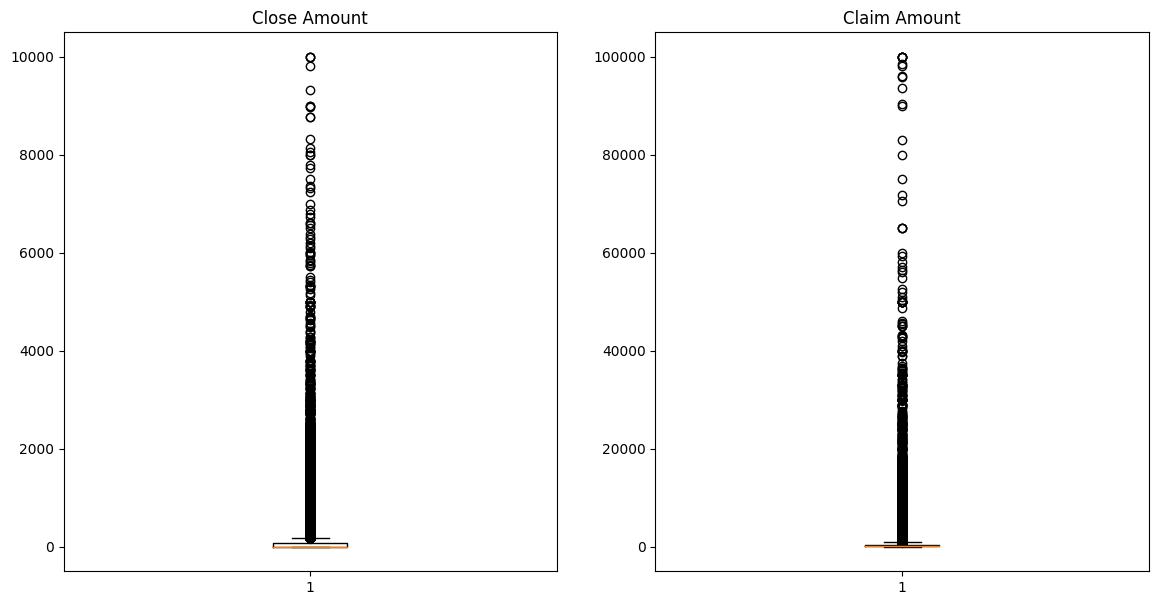

In [49]:
#Updated boxplot of Numerical Features

plt.subplots(1,2, figsize=(14,7))

plt.subplot(1,2,1)
plt.boxplot(x=new_df1["Close Amount"])
plt.title("Close Amount")

plt.subplot(1,2,2)
plt.boxplot(x=new_df1["Claim Amount"])
plt.title("Claim Amount")

plt.show()

In [50]:
new_df1.describe().T

,count,mean,min,25%,50%,75%,max,std
Date Received,118850,2006-03-12 23:22:23.495161984,1994-01-05 00:00:00,2004-08-27 00:00:00,2005-12-21 00:00:00,2007-09-19 00:00:00,2055-05-17 00:00:00,NaN
Incident Date,118850,2006-01-30 07:43:30.674463488,1996-05-08 00:00:00,2004-07-13 00:00:00,2005-11-10 00:00:00,2007-08-16 00:00:00,2010-06-22 00:00:00,NaN
Claim Amount,118850.0,579.889769,0.0,62.5825,175.0,450.0,100000.0,2085.338489
Close Amount,118850.0,89.535265,0.0,0.0,0.0,70.0,10000.0,289.7464
Date Received Year,118850.0,2005.704922,1994.0,2004.0,2005.0,2007.0,2055.0,1.868471
Incident Year,118850.0,2005.581287,1996.0,2004.0,2005.0,2007.0,2010.0,1.869816


In [51]:
new_df1.describe(include='object').T

,count,unique,top,freq
Airport Code,118850,424,LAX,5917
Airport Name,118850,424,Los Angeles International Airport,5917
Claim Type,118850,6,Passenger Property Loss,71534
Claim Site,118850,4,Checked Baggage,97002
Item,118850,3190,Other,24267
Disposition,118850,3,Deny,63217
Date Received Month,118850,12,Aug,11010
Incident Month,118850,12,Aug,10693


Reasons for excluding some features from the model development

- Given that the Item column has 3,193 unique values, encoding it might add excessive dimensionality to the dataset. This could increase complexity without significantly improving the clustering results.
- The goal is to identify claim patterns across airports (e.g., seasonal trends, high claim types), so removing the Airport Code and Airport Name columns could allow clusters to form based on these general patterns rather than just airport-specific data.
- Date Received Month indicates when the claim was submitted or processed, which might be influenced by factors unrelated to the actual incident timing. For example, processing delays or travel schedules could affect when a claim is filed relative to when the incident happened.

In [53]:
new_df1.loc[:,"Incident Month Num"]=pd.to_datetime(new_df1["Incident Date"]).dt.month

### Feature Engineering

In [64]:
#Dropping Irrevelant Columns
features= ["Claim Type", "Claim Site", "Claim Amount", "Close Amount", "Disposition", "Incident Month Num"]
df3= new_df1[features]

In [65]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118850 entries, 0 to 145143
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Claim Type          118850 non-null  object 
 1   Claim Site          118850 non-null  object 
 2   Claim Amount        118850 non-null  float64
 3   Close Amount        118850 non-null  float64
 4   Disposition         118850 non-null  object 
 5   Incident Month Num  118850 non-null  int32  
dtypes: float64(2), int32(1), object(3)
memory usage: 5.9+ MB


In [66]:
#Splitting df3 into numerical and Categorical features

num_feat= df3.select_dtypes(include=[np.number]).columns
cat_feat= df3.select_dtypes(exclude=[np.number]).columns

num_df3= df3[num_feat]
cat_df3=df3[cat_feat]

In [67]:
num_df3

,Claim Amount,Close Amount,Incident Month Num
0,350.00,350.00,12
1,100.00,50.00,1
2,278.88,227.92,11
3,50.00,50.00,1
4,84.79,84.79,2
...,...,...,...
145138,175.90,0.00,12
145139,695.00,0.00,12
145140,25.50,0.00,12
145141,20.00,0.00,12


#### Feature Encoding

In [70]:
#Encoding Using OneHotEncoder
#Because of the cyclical nature of months, the Incident Month column will be encoded using sine and cosine transformations

#Initializing OneHotEncoder

onehot_encoder= OneHotEncoder(sparse_output=False)
encoded_array= onehot_encoder.fit_transform(cat_df3)
encoded_df = pd.DataFrame(encoded_array, columns=onehot_encoder.get_feature_names_out(cat_df3.columns))

# Apply cosine and sine transformations
num_df3.loc[:,'Month Cosine'] = np.cos(2 * np.pi * num_df3['Incident Month Num'] / 12)
num_df3.loc[:,'Month Sine'] = np.sin(2 * np.pi * num_df3['Incident Month Num'] / 12)


In [69]:
#Concatenating the encoded and scaled features

df4 = pd.concat([num_df3.reset_index(drop=True),encoded_df.reset_index(drop=True)], axis=1)
df4

,Claim Amount,Close Amount,Incident Month Num,Month Cosine,Month Sine,Claim Type_Employee Loss (MPCECA),Claim Type_Motor Vehicle,Claim Type_Passenger Property Loss,Claim Type_Passenger Theft,Claim Type_Personal Injury,Claim Type_Property Damage,Claim Site_Checked Baggage,Claim Site_Checkpoint,Claim Site_Motor Vehicle,Claim Site_Other,Disposition_Approve in Full,Disposition_Deny,Disposition_Settle
0,350.00,350.00,12,1.000000,-2.449294e-16,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,100.00,50.00,1,0.866025,5.000000e-01,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,278.88,227.92,11,0.866025,-5.000000e-01,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,50.00,50.00,1,0.866025,5.000000e-01,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,84.79,84.79,2,0.500000,8.660254e-01,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118845,175.90,0.00,12,1.000000,-2.449294e-16,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
118846,695.00,0.00,12,1.000000,-2.449294e-16,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
118847,25.50,0.00,12,1.000000,-2.449294e-16,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
118848,20.00,0.00,12,1.000000,-2.449294e-16,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [71]:
updated_df= df4[["Claim Amount",	"Close Amount", "Disposition_Approve in Full",	"Disposition_Deny",	"Disposition_Settle" ]]
updated_df

,Claim Amount,Close Amount,Disposition_Approve in Full,Disposition_Deny,Disposition_Settle
0,350.00,350.00,1.0,0.0,0.0
1,100.00,50.00,0.0,0.0,1.0
2,278.88,227.92,0.0,0.0,1.0
3,50.00,50.00,1.0,0.0,0.0
4,84.79,84.79,1.0,0.0,0.0
...,...,...,...,...,...
118845,175.90,0.00,0.0,1.0,0.0
118846,695.00,0.00,0.0,1.0,0.0
118847,25.50,0.00,0.0,1.0,0.0
118848,20.00,0.00,0.0,1.0,0.0


In [72]:
#Standardizing the data
scaler= StandardScaler()
df_scaled= scaler.fit_transform(updated_df)
updated_df_scaled= pd.DataFrame(df_scaled, columns=updated_df.columns)
updated_df_scaled

,Claim Amount,Close Amount,Disposition_Approve in Full,Disposition_Deny,Disposition_Settle
0,-0.110241,0.898944,1.669130,-1.065984,-0.506185
1,-0.230127,-0.136448,-0.599114,-1.065984,1.975563
2,-0.144346,0.477608,-0.599114,-1.065984,1.975563
3,-0.254104,-0.136448,1.669130,-1.065984,-0.506185
4,-0.237420,-0.016377,1.669130,-1.065984,-0.506185
...,...,...,...,...,...
118845,-0.193729,-0.309014,-0.599114,0.938100,-0.506185
118846,0.055200,-0.309014,-0.599114,0.938100,-0.506185
118847,-0.265852,-0.309014,-0.599114,0.938100,-0.506185
118848,-0.268490,-0.309014,-0.599114,0.938100,-0.506185


## Assessing Clustering Tendency

### Visualizing the data using PCA

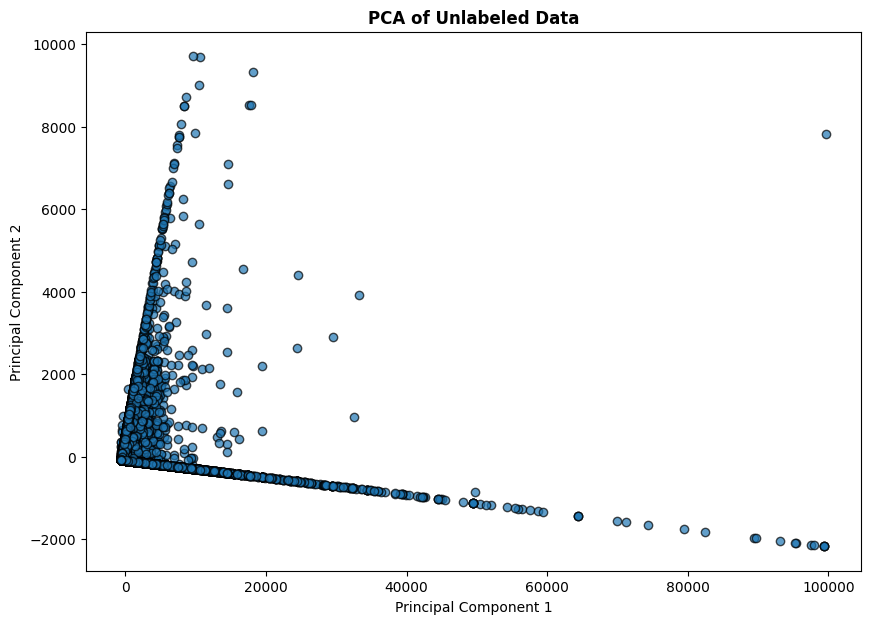

In [73]:
#PCA on data in 2D

pca= PCA(n_components=2)
df_pca= pca.fit_transform(updated_df)

principal_df= pd.DataFrame(df_pca, columns=["Principal Component 1", "Principal Component 2"])

plt.figure(figsize=(10, 7))
plt.scatter(principal_df['Principal Component 1'], principal_df['Principal Component 2'], alpha=0.7, edgecolor='k')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Unlabeled Data", fontweight='bold')
plt.show()

Based on the PCA scatter plot above, there appear to be some patterns in the data, but it is not immediately clear if there are distinct, well-separated clusters. Here are a few observations:

- Potential Grouping: There is a dense concentration of points around the origin (0,0), which might indicate a primary cluster or a region where a significant portion of the data is located.
- Outliers: There are points scattered away from the main dense area, which could represent outliers or potentially separate groups.
- Linear Structure: The data seems to form a triangular or "V" shape, which could indicate some underlying structure. However, this shape might suggest correlations between the features rather than natural clusters.

### Hopkins Statistical Analysis 

In [74]:
#Creating a random uniform dataset

X_uniform = np.random.uniform(updated_df.min(axis=0), updated_df.max(axis=0), (updated_df.shape))

#Standardizing the features
X_uniform_scaled= scaler.fit_transform(X_uniform)

#PCA on scaled uniform dataset
x_pca= pca.fit_transform(X_uniform_scaled)

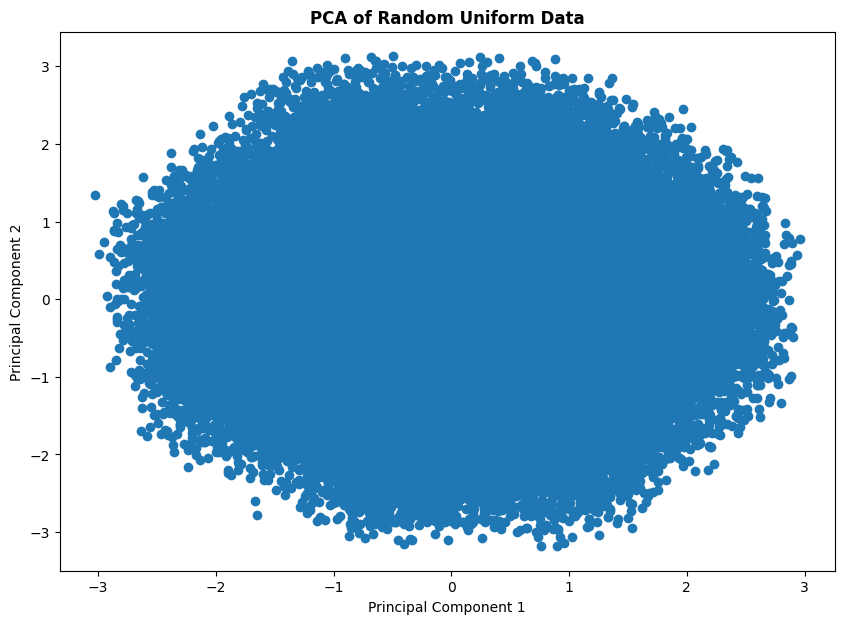

In [75]:
#Plotting the PCA Scatter plot of the uniform data 

plt.figure(figsize=(10,7))
plt.scatter(x_pca[:,0],x_pca[:,1])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Random Uniform Data", fontweight='bold')
plt.show()


In [76]:
#Hopkins Statistic Implementation

def hopkins_statistic(df):
    df=df.values #convert dataframe to array
    sample_size= int(df.shape[0] * 0.05) #0.05(5%) sample 
    
    #creating a uniform random sample in the data space
    x_uniform_random_sample= uniform(df.min(axis=0), df.max(axis=0), (sample_size, df.shape[1]))
    
    #creating a random sample of size sample_size from original dataframe
    random_indices= sample(range(0, df.shape[0], 1), sample_size)
    df_sample= df[random_indices]
    
    #initialize unsupervised learner for implementing neighbor searches
    neigh= NearestNeighbors(n_neighbors=2)
    nbrs= neigh.fit(df)
    
    #u_distances= nearest neighbor dstances from uniform random sample
    u_distances, u_indices= nbrs.kneighbors(df_sample, n_neighbors=2)
    u_distances= u_distances[:,0] #distance to the first nearest neighbor
    
    #w_distances= nearest neighbor distances from a sample of points from original data
    w_distances, w_indices= nbrs.kneighbors(df_sample, n_neighbors=2)
    #distance to th second nearest neighbor (as the first beighbor will be the point itself, with distances = 0)
    w_distances= w_distances[:,1]
    
    u_sum= np.sum(u_distances)
    w_sum= np.sum(w_distances)
    
    #Compute and return Hopkins Statistic
    H= u_sum/(u_sum + w_sum)
    
    return H

In [77]:
H= hopkins_statistic(updated_df)
print(f"The Hopkins Statistic is: {H}")

The Hopkins Statistic is: 0.0


In [78]:
hopkins = [] #list to hold values for each call
for i in range(20):
    H=hopkins_statistic(updated_df)
    hopkins.append(H)
#print average value:
Average_hopkins_statistic= np.mean(hopkins)
print(f"The average_hopkins_statistic is: {Average_hopkins_statistic}")

The average_hopkins_statistic is: 0.0


## Model Development

###  Partition-based Clustering

#### KMeans Clustering

In [79]:
#Finding the Optimal K

def optimise_k_means(df, max_k):
    k_values= []
    inertias= []
    silhouette_scores= []
    
    for k in range(2, max_k):
        kmeans= KMeans(n_clusters=k, n_init=20, random_state=42)
        kmeans.fit(df)
        labels= kmeans.fit_predict(df)
        
        k_values.append(k)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(df, labels))

#Generating Elbow Plot 
    plt.subplots(2,1, figsize=(14,14))
    
    plt.subplot(2,1,1)
    plt.plot(k_values, inertias, "o-")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.title("Elbow Plot", fontweight='bold')
    plt.grid(True)
    
#Generating Silhouette Score Plot
    plt.subplot(2,1,2)
    plt.plot(k_values, silhouette_scores, "o-")
    plt.title("Silhoutte Scores with varying K", fontweight='bold')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.grid(True)
    plt.tight_layout(pad=3)
    plt.show()

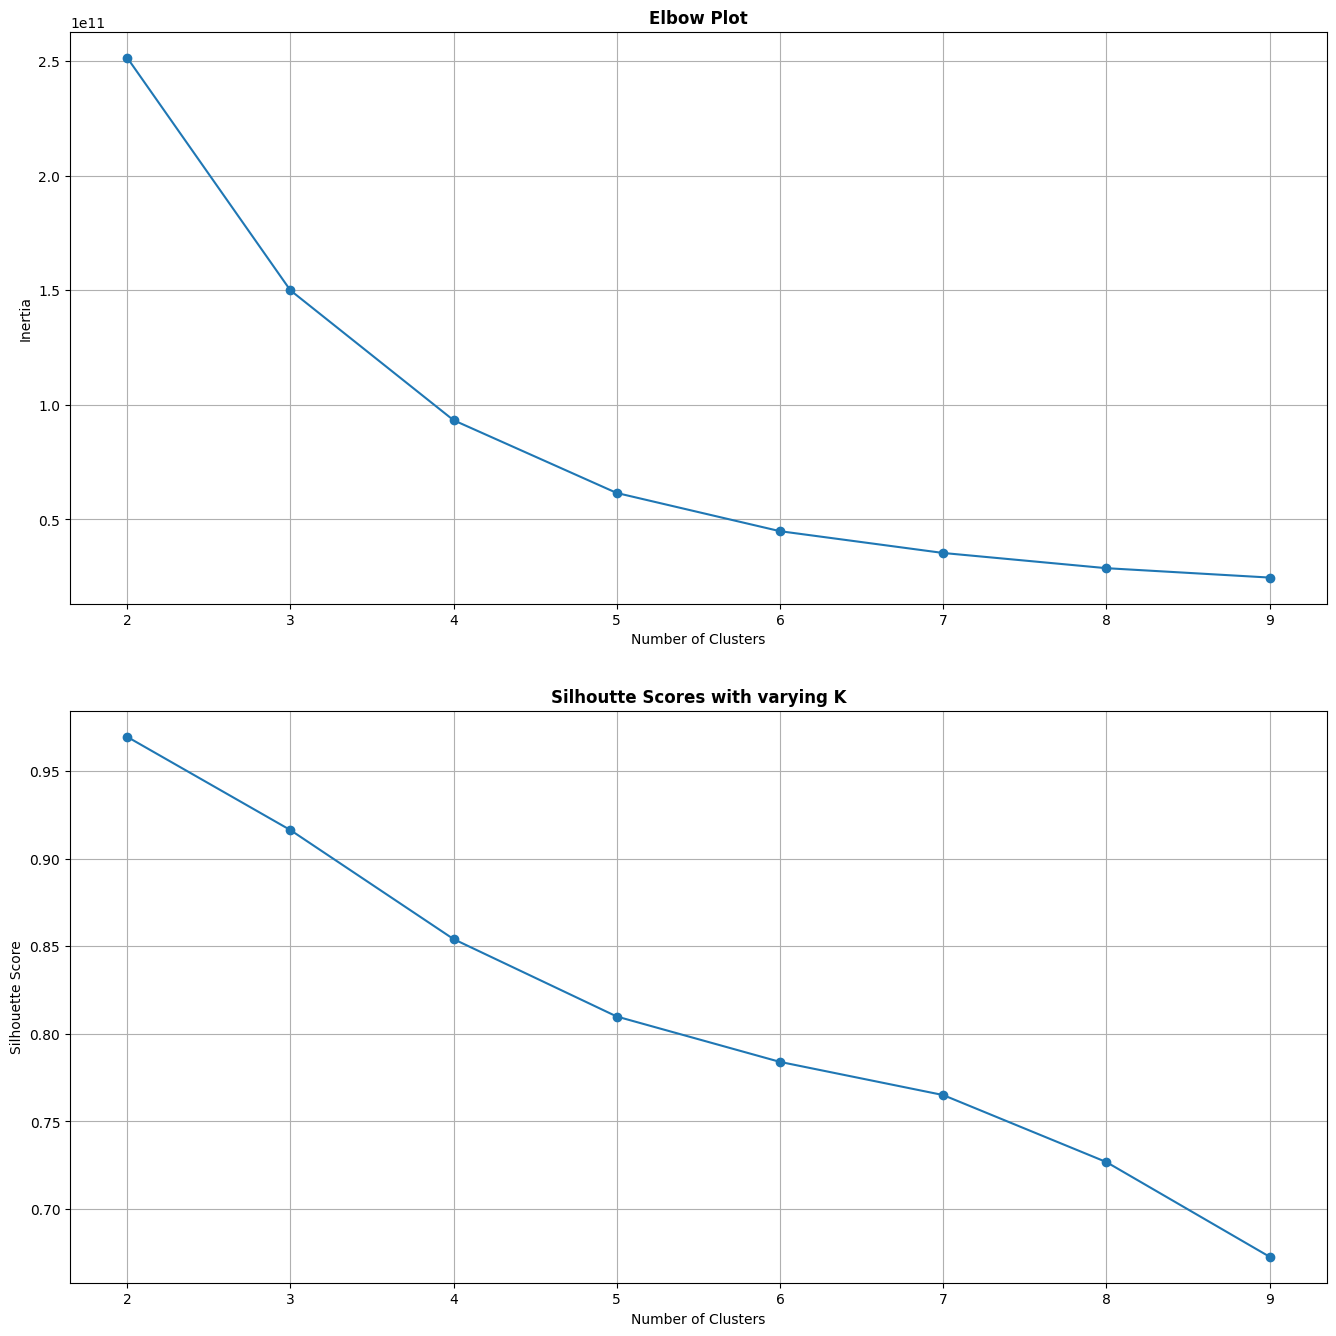

In [239]:
#Determining the optimal number of kmeans clusters

optimise_k_means(updated_df, 10)

In [ ]:
#Applying kmeans with n_clusters= 4 on the unscaled data

kmeans= KMeans(n_clusters=4)
kmeans.fit(updated_df)

new_df1.loc[:,"KMeans_labels"]= kmeans.labels_

In [252]:
new_df1.groupby("KMeans_labels")[num_feat].agg(["median", "mean"])

Claim Amount                ... Incident Month Num          
                    median          mean  ...             median      mean
KMeans_labels                             ...                             
0                   161.89    366.129774  ...                7.0  6.527258
1                 24930.00  26745.206314  ...                7.0  6.929412
2                  4861.15   5806.331492  ...                6.0  6.473373
3                 80000.00  79240.840741  ...               10.0  8.222222

[4 rows x 6 columns]

In [266]:
new_df1.groupby(['KMeans_labels']).agg(lambda x: pd.Series.mode(x).iat[0])[["Airport Code", "Airport Name", "Claim Type", "Claim Site", "Item", "Disposition", "Date Received Month", "Incident Month"]]

,Airport Code,Airport Name,Claim Type,Claim Site,Item,Disposition,Date Received Month,Incident Month
KMeans_labels,,,,,,,,
0,LAX,Los Angeles International Airport,Passenger Property Loss,Checked Baggage,Other,Deny,Aug,Jul
1,EWR,Miami International Airport,Passenger Property Loss,Checked Baggage,Jewelry - Fine,Deny,Oct,Sep
2,LAX,Los Angeles International Airport,Passenger Property Loss,Checked Baggage,Jewelry - Fine,Deny,Aug,Aug
3,JFK,John F. Kennedy International,Passenger Property Loss,Checked Baggage,Jewelry - Fine,Deny,Nov,Nov


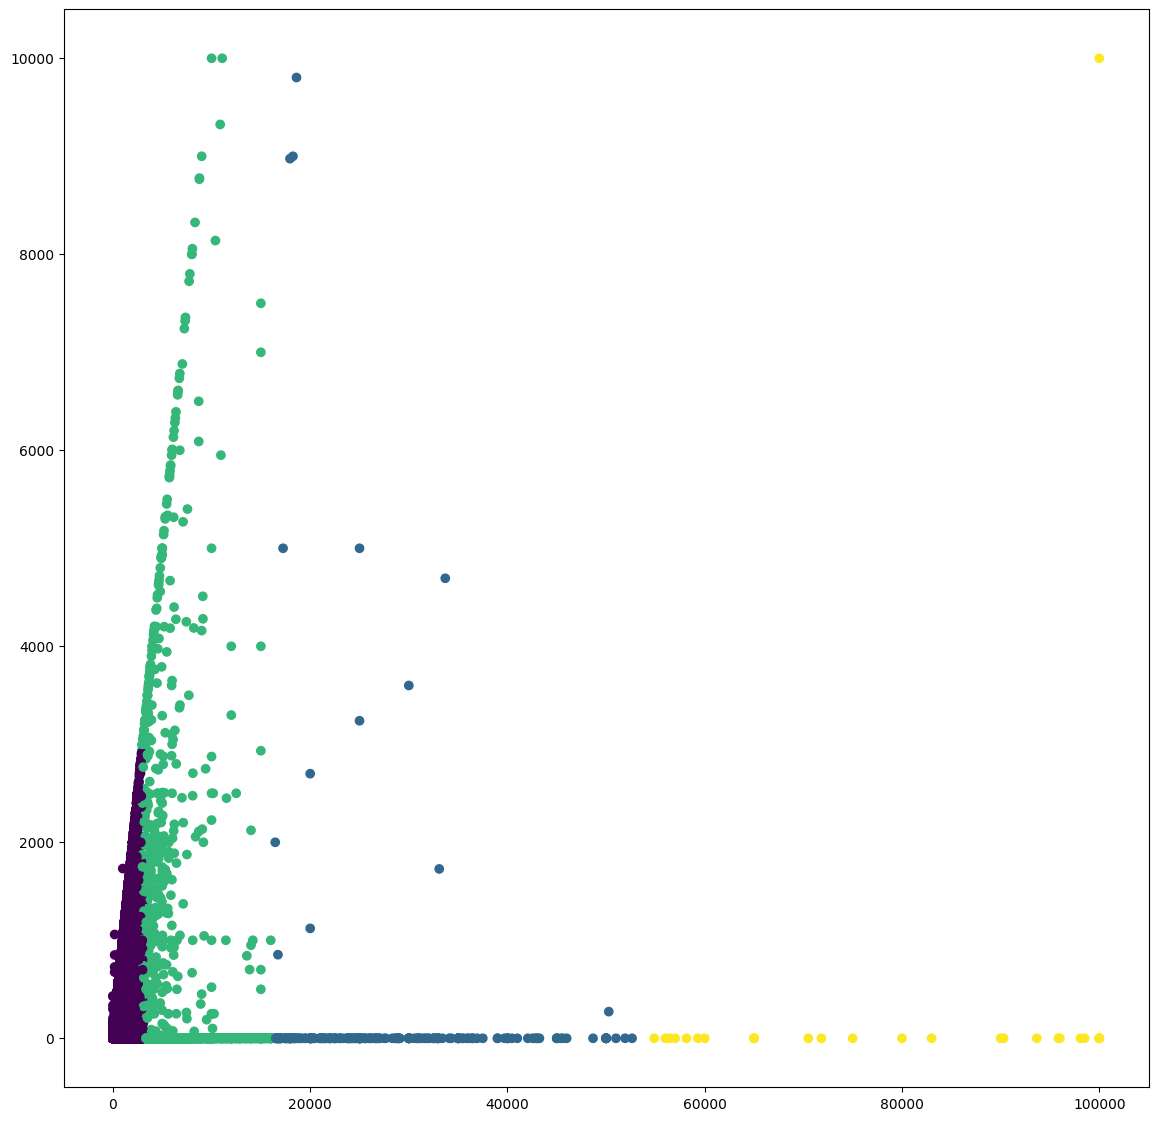

In [ ]:
plt.figure(figsize=(14,14))
plt.scatter(x=df4["Claim Amount"], y=df4["Close Amount"], c=new_df1["KMeans_labels"])

Next action- main kmeans model and silhouette score
kmedoids
clara
determine cluster centers and plot data based on new_df

Hierarchical Clustering
get labels and optimal clusters
dbscan get labels and clusters

### K-Prototype Clustering

In [268]:
new_data= df3.drop("Incident Month Num", axis=1)
new_data

,Claim Type,Claim Site,Claim Amount,Close Amount,Disposition
0,Property Damage,Checkpoint,350.00,350.00,Approve in Full
1,Property Damage,Checked Baggage,100.00,50.00,Settle
2,Property Damage,Checked Baggage,278.88,227.92,Settle
3,Property Damage,Checkpoint,50.00,50.00,Approve in Full
4,Property Damage,Checkpoint,84.79,84.79,Approve in Full
...,...,...,...,...,...
145138,Property Damage,Checked Baggage,175.90,0.00,Deny
145139,Passenger Property Loss,Checked Baggage,695.00,0.00,Deny
145140,Passenger Property Loss,Checked Baggage,25.50,0.00,Deny
145141,Passenger Property Loss,Checked Baggage,20.00,0.00,Deny


In [269]:
#Getting the indices of all categorical columns
catColPositions= [new_data.columns.get_loc(col) for col in new_data.select_dtypes("object").columns]

In [270]:
#Converting the dataframe to a matrix

new_data_matrix= new_data.to_numpy()

In [271]:
#Finding the Optimal K in the KPrototype

def optimise_KPrototype(df, max_k):
    k_values=[]
    costs= []
    
    for k in range(1, max_k):
        kProto= KPrototypes(n_clusters=k, random_state=42)
        kProto.fit_predict(df, categorical= catColPositions)
        k_values.append(k)
        costs.append(kProto.cost_)
        
    plt.figure(figsize=(14,14))
    plt.plot(k_values, costs, "o-")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Costs")
    plt.title("Elbow Plot", fontweight='bold')
    plt.grid(True)

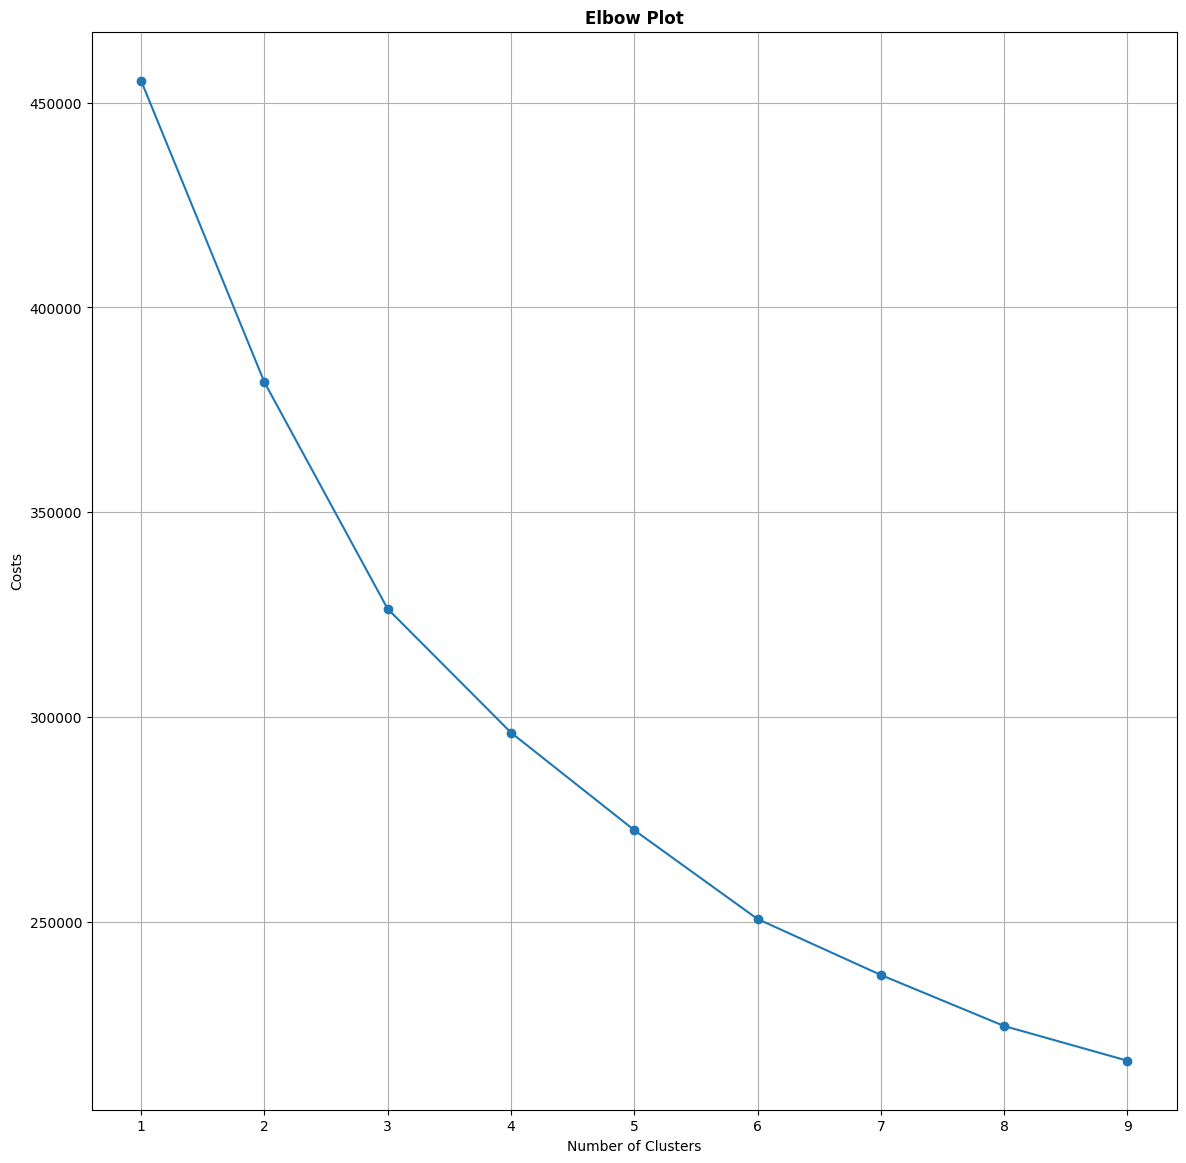

In [156]:
optimise_KPrototype(new_data_matrix, 10)

In [158]:
#Buiding the model with 6 clusters

kProto= KPrototypes(n_clusters=6, init="Cao", random_state=42)
new_df1["KPrototype_labels"]= kProto.fit_predict(new_data_matrix, categorical=catColPositions)

/var/folders/45/d0jt1g0523n27wc_qzf0j05c0000gn/T/ipykernel_11743/2830396833.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df1["KPrototype_labels"]= kProto.fit_predict(new_data_matrix, categorical=catColPositions)


In [165]:
new_df1.groupby("KPrototype_labels")[num_feat].agg(["mean", "median"])

Claim Amount            ... Incident Month Num       
                           mean    median  ...               mean median
KPrototype_labels                          ...                          
0                  46803.295897  39000.00  ...           7.025641    8.0
1                    203.859903    120.00  ...           6.462806    7.0
2                   6403.567447   5000.00  ...           6.250000    6.0
3                   1675.573778   1370.00  ...           6.465130    6.0
4                   9236.200842   7468.95  ...           6.631164    7.0
5                    460.010179    200.00  ...           6.560779    6.0

[6 rows x 6 columns]

In [168]:
#stats of categorical data by mode
new_df1.groupby(['KPrototype_labels']).agg(lambda x: pd.Series.mode(x).iat[0])[["Airport Code", "Airport Name", "Claim Type", "Claim Site", "Item", "Disposition", "Date Received Month", "Incident Month"]]


,Airport Code,Airport Name,Claim Type,Claim Site,Item,Disposition,Date Received Month,Incident Month
KPrototype_labels,,,,,,,,
0,JFK,John F. Kennedy International,Passenger Property Loss,Checked Baggage,Jewelry - Fine,Deny,Oct,Sep
1,LAX,Los Angeles International Airport,Property Damage,Checked Baggage,Luggage (all types including footlockers),Approve in Full,Jul,Jul
2,JFK,John F. Kennedy International,Passenger Property Loss,Checked Baggage,Jewelry - Fine,Settle,Mar,Apr
3,LAX,Los Angeles International Airport,Passenger Property Loss,Checked Baggage,Computer - Laptop,Settle,Jun,Apr
4,LAX,Los Angeles International Airport,Passenger Property Loss,Checked Baggage,Jewelry - Fine,Deny,Aug,Aug
5,LAX,Los Angeles International Airport,Passenger Property Loss,Checked Baggage,Other,Deny,Jan,Mar


### Hierarchical Clustering

In [1]:
#With Complete Linkage
linkage_matrix= sch.linkage(updated_df, metric="euclidean", method="complete")

NameError: name 'sch' is not defined

In [191]:
new_data1

,Claim Type,Claim Site,Item,Claim Amount,Close Amount,Disposition,Date Received Month,Incident Month,Claim Amount Scaled,Close Amount Scaled
0,Property Damage,Checkpoint,Other,350.00,350.00,Approve in Full,Jan,Dec,-0.110241,0.898944
1,Property Damage,Checked Baggage,Luggage (all types including footlockers),100.00,50.00,Settle,Feb,Jan,-0.230127,-0.136448
2,Property Damage,Checked Baggage,Cell Phones,278.88,227.92,Settle,Feb,Nov,-0.144346,0.477608
3,Property Damage,Checkpoint,Luggage (all types including footlockers),50.00,50.00,Approve in Full,Feb,Jan,-0.254104,-0.136448
4,Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,84.79,84.79,Approve in Full,Feb,Feb,-0.237420,-0.016377
...,...,...,...,...,...,...,...,...,...,...
145138,Property Damage,Checked Baggage,Luggage (all types including footlockers),175.90,0.00,Deny,Dec,Dec,-0.193729,-0.309014
145139,Passenger Property Loss,Checked Baggage,Cell Phones (smartphone type-blackberry; iphon...,695.00,0.00,Deny,Dec,Dec,0.055200,-0.309014
145140,Passenger Property Loss,Checked Baggage,Locks,25.50,0.00,Deny,Dec,Dec,-0.265852,-0.309014
145141,Passenger Property Loss,Checked Baggage,Locks,20.00,0.00,Deny,Dec,Dec,-0.268490,-0.309014
